In [1]:
# !pip install statsmodels
# !pip install ruptures
# !pip install ipdb
# !pip install pwlf
import ipdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import random
import statsmodels.api as sm
from numpy.polynomial.polynomial import Polynomial
from statsmodels.tsa.filters.hp_filter import hpfilter
import pickle

In [2]:
class TimeSeriesGenerator:
  def __init__(self, length=None):
    self.length = length if length is not None else 400
    self.base_distributions = ['ar', 'ma', 'arma']
    self.characteristics = {'deterministic_trend_linear' : self.generate_deterministic_trend_linear,
    'deterministic_trend_cubic': self.generate_deterministic_trend_cubic,
    'deterministic_trend_quadratic': self.generate_deterministic_trend_quadratic,
    'stochastic_trend': self.generate_stochastic_trend,
    'seasonality': self.generate_seasonality}
    self.structural_breaks = {'mean_shift': self.generate_mean_shift,
    'variance_shift': self.generate_variance_shift,
    'trend_shift': self.generate_trend_shift,
    'gradual_change_mean': self.generate_gradual_mean_shift,
    'gradual_change_variance': self.generate_gradual_variance_shift,
    'gradual_change_trend': self.generate_gradual_trend_shift}

  def z_normalize(self,series):
    return (series - np.mean(series)) / np.std(series)

  def is_stationary(self, ar_params):
    # Check if AR parameters lead to stationarity
    ar_poly = np.r_[1, -ar_params]
    roots = Polynomial(ar_poly).roots()
    return np.all(np.abs(roots) > 1)

  def is_invertible(self, ma_params):
    # Check if MA parameters lead to invertibility
    ma_poly = np.r_[1, ma_params]
    roots = Polynomial(ma_poly).roots()
    return np.all(np.abs(roots) > 1)

  def extract_seasonal_part(self,series, period):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    return seasonal

  def generate_ar_params(self, order_range=(1, 3), coef_range=(-0.3, 0.3)):
    while True:
      order = np.random.randint(order_range[0], order_range[1] + 1)
      coefs = np.random.uniform(coef_range[0], coef_range[1], order)
      ar = np.r_[1, -coefs]
      ma = np.array([1])
      arma_process = ArmaProcess(ar, ma)
      if arma_process.isstationary:
        break
    return order, coefs

  def generate_ma_params(self, order_range=(1, 3), coef_range=(-0.3, 0.3)):
    while True:
      order = np.random.randint(order_range[0], order_range[1] + 1)
      coefs = np.random.uniform(coef_range[0], coef_range[1], order)
      ma = np.r_[1, coefs]
      ar = np.array([1])
      arma_process = ArmaProcess(ar, ma)
      if arma_process.isinvertible:
        break
    return order, coefs

  def generate_arma_params(self, order_range=(1, 3), coef_range=(-0.3, 0.3)):
    while True:
      ar_order = np.random.randint(order_range[0], order_range[1] + 1)
      ma_order = np.random.randint(order_range[0], order_range[1] + 1)
      ar_coefs = np.random.uniform(coef_range[0], coef_range[1], ar_order)
      ma_coefs = np.random.uniform(coef_range[0], coef_range[1], ma_order)
      ma = np.r_[1, ma_coefs]
      ar = np.r_[1, -ar_coefs]
      arma_process = ArmaProcess(ar, ma)
      if arma_process.isinvertible and arma_process.isstationary:
        break
    return ar_order, ma_order, ar_coefs, ma_coefs

  def generate_sarima_params(self, p_range=(1, 3), d_range=(0, 1), q_range=(1, 3), seasonal_order=(1, 1, 1, 12), coef_range=(-0.2, 0.2)):
    while True:
      p = np.random.randint(p_range[0], p_range[1] + 1)
      d = np.random.randint(d_range[0], d_range[1] + 1)
      q = np.random.randint(q_range[0], q_range[1] + 1)
      P, D, Q, s = seasonal_order

      ar_params = np.random.uniform(coef_range[0], coef_range[1], p)
      ma_params = np.random.uniform(coef_range[0], coef_range[1], q)

      seasonal_ar_params = np.random.uniform(coef_range[0], coef_range[1], P)
      seasonal_ma_params = np.random.uniform(coef_range[0], coef_range[1], Q)

      if self.is_stationary(ar_params) and self.is_invertible(ma_params) and self.is_stationary(seasonal_ar_params) and self.is_invertible(seasonal_ma_params):
        params = np.concatenate(([0], ar_params, ma_params, seasonal_ar_params, seasonal_ma_params))
        return (p, d, q), (P, D, Q, s), params

  def generate_white_noise(self, length, noise_scale = 0.05):
    series = np.random.normal(0, 0.05, length)
    series = series * noise_scale
    return series

  def generate_ar_series(self, length, noise_scale = 0.5):
    order,coefs = self.generate_ar_params()
    ar = np.r_[1, -np.array(coefs)]  # leading 1 and negate the coefficients
    ma = np.r_[1]  # MA coefficients are just [1] for a pure AR process
    ar_process = ArmaProcess(ar, ma)
    series = ar_process.generate_sample(nsample=length)
    series = series * noise_scale
    return series

  def generate_ma_series(self, length, noise_scale = 0.5):
    order,coefs = self.generate_ma_params()
    ar = np.r_[1]  # AR coefficients are just [1] for a pure MA process
    ma = np.r_[1, np.array(coefs)]  # leading 1 for the MA coefficients
    arma_process = ArmaProcess(ar, ma)
    series = arma_process.generate_sample(nsample=length)
    series = series * noise_scale
    return series

  def generate_arma_series(self, length, noise_scale = 0.5):
    ar_order,ma_order,ar_coefs,ma_coefs = self.generate_arma_params()
    ar = np.r_[1, -np.array(ar_coefs)]
    ma = np.r_[1, np.array(ma_coefs)]
    arma_process = ArmaProcess(ar, ma)
    series = arma_process.generate_sample(nsample=length)
    series = series * noise_scale
    return series

  def generate_sarima_series(self, length, noise_scale=0.5, max_attempts=10):
    attempts = 0
    while attempts < max_attempts:
      try:
        order, seasonal_order, params = self.generate_sarima_params()
        p, d, q = order
        P, D, Q, s = seasonal_order

        sarima_model = SARIMAX(endog=np.zeros(length), order=(p, d, q), seasonal_order=(P, D, Q, s))

        series = sarima_model.simulate(params=params, nsimulations=length)
        if not np.isnan(series).any():
          return series * noise_scale

      except (ValueError, np.linalg.LinAlgError):
        attempts += 1
        print(f"Attempt {attempts}/{max_attempts} failed due to numerical instability. Retrying with new parameters...")

    raise ValueError("Failed to generate a stable SARIMA series after multiple attempts.")

  def generate_base_series(self, distribution=None):
    if distribution is None:
      distribution = np.random.choice(self.base_distributions)
    if distribution == 'white_noise':
      series = self.generate_white_noise(self.length)
    elif distribution == 'ar':
      series = self.generate_ar_series(self.length)
    elif distribution == 'ma':
      series = self.generate_ma_series(self.length)
    elif distribution == 'arma':
      series = self.generate_arma_series(self.length)
    elif distribution == 'sarima':
      series = self.generate_sarima_series(self.length)

    df = pd.DataFrame({
    'data': series,
    'mean_shift': (np.zeros(self.length)).astype(int),
    'variance_shift': (np.zeros(self.length)).astype(int),
    'trend_shift': (np.zeros(self.length)).astype(int),
    'anomaly': (np.zeros(self.length)).astype(int),})
    return df

  def generate_point_anomalies(self, df, scale_factor=1):
    series = df['data'].copy()
    series = self.z_normalize(series)
    num_anomalies = np.random.randint(int(len(series)*0.01), int(len(series)*0.05))
    magnitude = np.random.uniform(3,6)
    anomaly_indices = np.random.choice(len(series), num_anomalies, replace=False)
    series[anomaly_indices] += np.random.choice([-1, 1], num_anomalies) * magnitude * np.std(series) * scale_factor
    df.loc[:,'data'] = series
    df.loc[anomaly_indices,'anomaly'] = 1
    return df

  def generate_collective_anomalies(self, df, change_type = None, scale_factor = 1, seasonal_period = None):
    series = df['data'].copy()
    series = self.z_normalize(series)
    start = np.random.randint(int(len(series)*0.1), int(len(series)*0.9))
    anomaly_length = np.random.randint(int(len(series))*0.05, int(len(series)*0.09))
    end = start + anomaly_length
    magnitude = np.random.uniform(1.5,2.5)
    sign = np.random.choice([-1, 1])
    if change_type == 'mean':
      series[start:end] += sign * np.ones(anomaly_length) * magnitude * np.std(series) * scale_factor
    elif change_type == 'variance':
      if sign == 1:
        series[start:end] *= magnitude * np.std(series) * scale_factor
      elif sign == -1:
        series[start:end] *= (1/magnitude) * np.std(series) * scale_factor
    elif change_type == 'seasonal':
      distortion_factor = np.random.uniform(0.5, 2)
      distorted_seasonality = np.sin(2 * np.pi * np.arange(anomaly_length) / (seasonal_period * distortion_factor))
      series[start:end] += sign * distorted_seasonality * magnitude * scale_factor
    else:
      raise ValueError("Invalid change_type. Expected 'mean', 'variance', or 'seasonal'.")
    df.loc[:,'data'] = series
    df.loc[start:end,'anomaly'] = 1
    return df

  def generate_deterministic_trend_linear(self, df, sign = None, slope= None, noise_std = None, intercept = 1, scale_factor = 1):
    series = df['data'].copy()
    noise_std = noise_std if noise_std is not None else np.random.uniform(0.1, 1.5)
    if len(series) == 100:
        slope_range = [0.4, 0.5, 0.6, 0.7, 0.8]
        scale_factor = 4
    else:
        slope_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        scale_factor = 1
    slope = slope if slope is not None else random.choice(slope_range)*sign
    trend = intercept + slope * np.arange(len(series)) + np.random.normal(0, noise_std, len(series))
    series += trend * scale_factor
    series = self.z_normalize(series)
    df.loc[:,'data'] = series
    return df

  def generate_deterministic_trend_cubic(self, df, sign = None, a=None, b=None, c=None, d=None, noise_std=None, scale_factor = 1):
    series = df['data'].copy()
    noise_std = noise_std if noise_std is not None else np.random.uniform(0.1, 1.5)
    if len(series) == 100:
        scale_factor = 5
    else:
        scale_factor = 1
    a = a if a is not None else sign * random.uniform(0.0000001, 0.000001)
    b = b if b is not None else sign * random.uniform(0.0001, 0.001)
    c = c if c is not None else sign * random.uniform(0.01, 0.1)
    d = d if d is not None else sign * random.uniform(1, 10)
    trend = (a * (np.arange(len(series)))**3 + b * (np.arange(len(series)))**2 + c * (np.arange(len(series))) + d) * scale_factor + np.random.normal(0, noise_std, len(series))
    series += trend
    series = self.z_normalize(series)
    df.loc[:,'data'] = series
    return df

  def generate_deterministic_trend_quadratic(self, df, sign = None, a=None, b=None, c=None, noise_std=None, scale_factor =1):
    series = df['data'].copy()
    noise_std = noise_std if noise_std is not None else np.random.uniform(0.1, 1.5)
    if len(series) == 100:
        scale_factor = 5
    else:
        scale_factor = 1
    a = a if a is not None else sign * random.uniform(0.0001, 0.001)
    b = b if b is not None else sign * random.uniform(0.001, 0.01)
    c = c if c is not None else sign * random.uniform(1, 10)
    trend = (a * (np.arange(len(series)))**2 + b * (np.arange(len(series))) + c) * scale_factor + np.random.normal(0, noise_std, len(series))
    series += trend
    series = self.z_normalize(series)
    df.loc[:,'data'] = series
    return df

  def generate_stochastic_trend(self, df, sign = None, drift=None, noise_std=None, scale_factor=1):
    series = df['data'].copy()
    noise_std = noise_std if noise_std is not None else np.random.uniform(0.1, 1.5)
    if len(series) == 100:
        drift_range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        scale_factor = 4
    else:
        drift_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        scale_factor = 1
    drift = drift if drift is not None else random.choice(drift_range) * sign
    random_walk = np.cumsum(np.random.normal(0, noise_std, len(series))) * scale_factor
    trend = drift * np.arange(len(series)) * scale_factor + random_walk
    series += trend
    series = self.z_normalize(series)
    df.loc[:,'data'] = series
    return df

  def generate_seasonality(self, df, period=None, amplitude=None, noise_std=None, scale_factor = 3):
    series = df['data'].copy()
    noise_std = noise_std if noise_std is not None else np.random.uniform(0.01, 0.05)
    min_period = 5  
    max_period = len(series) // 6  # Ensure at least 6 cycles
    periods = [p for p in [5, 7, 12, 24, 30, 52, 90, 180] if min_period <= p <= max_period]
    period = period if period is not None else random.choice(periods)
    amplitude = amplitude if amplitude is not None else np.std(series) * np.random.uniform(0.5, 2.5)
    seasonality = (amplitude * np.sin(2 * np.pi * np.arange(len(series)) / period) + np.random.normal(0, noise_std, size = len(series)))
    series += seasonality * scale_factor
    series = self.z_normalize(series)
    df.loc[:,'data'] = series
    return period, df

  def generate_mean_shift(self, df, sign = None, location=None, num_breaks=1, scale_factor=1, seasonal_period = None):
    series = df['data'].copy()
    noise = np.random.uniform(0.1, 1.5)
    n = len(series)
    mean = np.mean(series)
    std = np.std(series)
    residuals, trend = hpfilter(series, lamb=11000)
    min_break_length = int(0.1 * n) 
    max_break_length = int(0.2 * n)

    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n) 
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n)
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)

      if seasonal_period:
        phase = break_point % seasonal_period
        break_point -= phase 

      break_length =  np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      if seasonal_period:
        phase_end = break_end_point % seasonal_period
        break_end_point -= phase_end
        break_end_point = min(break_end_point, n)

      magnitude = np.random.uniform(0.5, 2)
      level_shift = sign * magnitude

      if seasonal_period:
        transition_length = max(1, seasonal_period // 2)
        transition_start = max(0, break_point - transition_length)
        transition_end = min(n, break_end_point + transition_length)

        sigmoid_transition = np.linspace(-6, 6, transition_end - transition_start)
        smooth_weights = 1 / (1 + np.exp(-sigmoid_transition))

        trend[transition_start:break_point] += smooth_weights[: break_point - transition_start] * level_shift * scale_factor
        trend[break_point:break_end_point] += level_shift * scale_factor
        trend[break_end_point:transition_end] += smooth_weights[break_end_point - transition_start :] * level_shift * scale_factor

        created_breaks.append((break_point, break_end_point))

      else:
        trend[break_point:break_end_point] += level_shift * scale_factor
        created_breaks.append((break_point, break_end_point))

    else:
      segment_size = n // num_breaks
      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue

        break_point = np.random.randint(start, end - min_break_length + 1)
        if seasonal_period:
          phase = break_point % seasonal_period
          break_point -= phase

        max_possible_length = int(n - break_point)
        break_length = np.random.randint(min_break_length, min(max_possible_length, max_break_length) + 1)
        break_end_point = break_point + break_length

        if seasonal_period:
          phase_end = break_end_point % seasonal_period
          break_end_point -= phase_end
          break_end_point = min(break_end_point, n)

        magnitude = np.random.uniform(0.5, 1.5)
        level_shift = sign * magnitude

        if seasonal_period:
          transition_length = max(1, seasonal_period // 2) 
          transition_start = max(0, break_point - transition_length)
          transition_end = min(n, break_end_point + transition_length)

          sigmoid_transition = np.linspace(-6, 6, transition_end - transition_start)
          smooth_weights = 1 / (1 + np.exp(-sigmoid_transition))

          trend[transition_start:break_point] += smooth_weights[: break_point - transition_start] * level_shift * scale_factor
          trend[break_point:break_end_point] += level_shift * scale_factor
          trend[break_end_point:transition_end] += smooth_weights[break_end_point - transition_start :] * level_shift * scale_factor

          created_breaks.append((break_point, break_end_point))

        else:
          trend[break_point:break_end_point] += level_shift * scale_factor
          created_breaks.append((break_point, break_end_point))

    series = residuals + trend
    series += noise
    series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'mean_shift'] = 1

    df.loc[:,'data'] = series
    return df

  def generate_variance_shift(self, df, sign = None, location=None, num_breaks=1, scale_factor=1, seasonal_period = None):
    series = df['data'].copy()
    n = len(series)
    mean = np.mean(series)
    std = np.std(series)
    residuals, trend = hpfilter(series, lamb=11000)

    min_break_length = int(0.1 * n)
    max_break_length = int(0.2 * n)

    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n ), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n)
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n)
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)

      if seasonal_period:
        phase = break_point % seasonal_period
        break_point -= phase 

      break_length =  np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      if seasonal_period:
        phase_end = break_end_point % seasonal_period
        break_end_point -= phase_end
        break_end_point = min(break_end_point, n)

      variance_factor = np.random.uniform(1.5, 3)
      if sign == 1:
        residuals[break_point:break_end_point] *= variance_factor * scale_factor
      elif sign == -1:
        residuals[:break_point] *= variance_factor * scale_factor
        residuals[break_end_point:] *= variance_factor * scale_factor
      else:
        raise ValueError("Invalid sign. Expected 1 or -1.")

      created_breaks.append((break_point, break_end_point))

    else:
      segment_size = n // num_breaks
      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue 

        break_point = np.random.randint(start, end - min_break_length + 1)

        if seasonal_period:
          phase = break_point % seasonal_period
          break_point -= phase

        break_length = np.random.randint(min_break_length, min(max_break_length, end - break_point + 1))
        break_end_point = break_point + break_length

        if seasonal_period:
          phase_end = break_end_point % seasonal_period
          break_end_point -= phase_end
          break_end_point = min(break_end_point, n)

        variance_factor = np.random.uniform(1.5, 3)

        if sign == 1:
          residuals[break_point:break_end_point] *= variance_factor * scale_factor
        elif sign == -1:
          residuals[:break_point] *= variance_factor * scale_factor
          residuals[break_end_point:] *= variance_factor * scale_factor
        else:
          raise ValueError("Invalid sign. Expected 1 or -1.")

        created_breaks.append((break_point, break_end_point))

    series = residuals + trend
    series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'variance_shift'] = 1

    df.loc[:,'data'] = series
    return df

  def generate_trend_shift(self, df, sign=None, location=None, num_breaks=1, change_type=None, seasonal_period = None, scale_factor = 1):
    series = df['data'].copy()
    noise = np.random.uniform(0.1, 1.5)
    n = len(series)
    mean = np.mean(series)
    if seasonal_period:
      seasonality = self.extract_seasonal_part(series, seasonal_period)
    positive_slopes = [0.1, 0.2, 0.3, 0.4, 0.5]
    negative_slopes = [-0.1, -0.2, -0.3, -0.4, -0.5]
    min_break_length = int(0.1 * n)
    max_break_length = int(0.2 * n)
    slope_change_factor = np.random.uniform(3, 6)
    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n)
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n)
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)
      if seasonal_period:
        phase = break_point % seasonal_period
        break_point -= phase

      break_length =  np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      if seasonal_period:
        phase_end = break_end_point % seasonal_period
        break_end_point -= phase_end
        break_end_point += seasonal_period
        break_end_point = min(break_end_point, n)

      if change_type == 'direction_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (-slope * np.arange(break_end_point-break_point)) + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (-slope * np.arange(break_end_point-break_point) + residuals[break_point:break_end_point] )
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1) + residuals[break_end_point:])
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      elif change_type == 'magnitude_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor + residuals[break_point:break_end_point])
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1) + residuals[break_end_point:])
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor + residuals[break_point:break_end_point])
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1) + residuals[break_end_point:])
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      elif change_type == 'direction_and_magnitude_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor + residuals[break_point:break_end_point])
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1) + residuals[break_end_point:])
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor + residuals[break_point:break_end_point])
          post_break_offset = series[break_end_point - 1]
          series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1) + residuals[break_end_point:])
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      else:
        raise ValueError("Invalid change_type. Expected 'direction_change', 'magnitude_change' or 'direction_and_magnitude_change.")

      created_breaks.append((break_point, break_end_point))

    else:
      segment_size = n // num_breaks
      positive_slope = np.random.choice(positive_slopes)  
      negative_slope = np.random.choice(negative_slopes)
        
      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue

        break_point = np.random.randint(start, end - min_break_length + 1)
        if seasonal_period:
          phase = break_point % seasonal_period
          break_point -= phase

        break_length = np.random.randint(min_break_length, min(max_break_length, end - break_point + 1))
        break_end_point = break_point + break_length

        if seasonal_period:
          phase_end = break_end_point % seasonal_period
          break_end_point -= phase_end
          break_end_point += seasonal_period
          break_end_point = min(break_end_point, n)

        if change_type == 'direction_change':
          if sign == 1:
            slope = positive_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point)) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          elif sign == -1:
            slope = negative_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point)) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        elif change_type == 'magnitude_change':
          if sign == 1:
            slope = positive_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          elif sign == -1:
            slope = negative_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        elif change_type == 'direction_and_magnitude_change':
          if sign == 1:
            slope = positive_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          elif sign == -1:
            slope = negative_slope
            series += slope * np.arange(n)
            residuals, trend = hpfilter(series, lamb=11000)
            offset = series[break_point]
            series[break_point:break_end_point] = offset + (-slope * slope_change_factor * np.arange(break_end_point-break_point) * scale_factor) + residuals[break_point:break_end_point]
            post_break_offset = series[break_end_point - 1]
            series[break_end_point:] = post_break_offset + (slope * np.arange(1, n - break_end_point + 1)) + residuals[break_end_point:]
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        else:
          raise ValueError("Invalid change_type. Expected 'direction_change', 'magnitude_change' or 'direction_and_magnitude_change'.")

        created_breaks.append((break_point, break_end_point))

    if seasonal_period:
      series[:break_point] += seasonality[:break_point] * 3
      series[break_point:] += seasonality[break_point:] * 4
      series += noise
      series = self.z_normalize(series)
    else:
      series += noise
      series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'trend_shift'] = 1

    df.loc[:,'data'] = series
    return df

  def generate_gradual_mean_shift(self, df, sign=None, location=None, num_breaks=1, scale_factor=2):
    series = df['data'].copy()
    noise = np.random.uniform(0.1, 1.5)
    n = len(series)
    mean = np.mean(series)
    std = np.std(series)
    residuals, trend = hpfilter(series, lamb=11000)

    min_break_length = int(0.1 * n)
    max_break_length = int(0.2 * n)

    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n)
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n) 
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)
      break_length = np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      transition_length = int(0.2 * break_length)
      main_shift_length = break_length - 2 * transition_length

      if main_shift_length <= 0:
        raise ValueError("Break length is too small for meaningful transitions.")

      magnitude = np.random.uniform(0.5, 2)
      level_shift = sign * magnitude * scale_factor

      start_transition = np.linspace(0, level_shift, transition_length)
      main_shift = np.ones(main_shift_length) * level_shift
      end_transition = np.linspace(level_shift, 0, transition_length)

      total_shift = np.concatenate([start_transition, main_shift, end_transition])

      trend[break_point:break_point + len(total_shift)] += total_shift
      created_breaks.append((break_point, break_point + len(total_shift)))

    else:
      segment_size = n // num_breaks
      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue

        break_point = np.random.randint(start, end - min_break_length + 1)
        max_possible_length = int(n - break_point)
        break_length = np.random.randint(min_break_length, min(max_possible_length, max_break_length) + 1)
        break_end_point = break_point + break_length

        transition_length = int(0.1 * break_length)
        main_shift_length = break_length - 2 * transition_length

        if main_shift_length <= 0:
          continue

        magnitude = np.random.uniform(0.5, 2)
        level_shift = sign * magnitude * scale_factor

        start_transition = np.linspace(0, level_shift, transition_length)
        main_shift = np.ones(main_shift_length) * level_shift
        end_transition = np.linspace(level_shift, 0, transition_length)

        total_shift = np.concatenate([start_transition, main_shift, end_transition])

        trend[break_point:break_point + len(total_shift)] += total_shift
        created_breaks.append((break_point, break_point + len(total_shift)))

    series = residuals + trend
    series += noise
    series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'mean_shift'] = 1

    df.loc[:,'data'] = series
    return df

  def generate_gradual_variance_shift(self, df, sign=None, location=None, num_breaks=1, scale_factor=1):
    series = df['data'].copy()
    n = len(series)
    mean = np.mean(series)
    std = np.std(series)
    residuals, trend = hpfilter(series, lamb=11000)

    min_break_length = int(0.1 * n)
    max_break_length = int(0.2 * n)

    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n)
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n)
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)
      break_length = np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      transition_length = int(0.2 * break_length)
      main_shift_length = break_length - 2 * transition_length

      if main_shift_length <= 0:
        raise ValueError("Break length is too small for meaningful transitions.")

      target_variance_factor = np.random.uniform(1.5, 3)

      if sign == 1:
        start_transition = np.linspace(1, target_variance_factor, transition_length)
        main_shift = np.ones(main_shift_length) * target_variance_factor
        end_transition = np.linspace(target_variance_factor, 1, transition_length)

        total_shift = np.concatenate([start_transition, main_shift, end_transition])

        residuals[break_point:break_point + len(total_shift)] *= total_shift
      elif sign == -1:
        start_transition = np.linspace(1/target_variance_factor, 1, transition_length)
        main_shift = np.ones(main_shift_length) * 1/target_variance_factor
        end_transition = np.linspace(1, 1/target_variance_factor, transition_length)

        total_shift = np.concatenate([start_transition, main_shift, end_transition])

        residuals[break_point:break_point + len(total_shift)] *= total_shift
      else:
        raise ValueError("Invalid sign. Expected 1 or -1.")

      created_breaks.append((break_point, break_point + len(total_shift)))

    else:
      segment_size = n // num_breaks
      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue 

        break_point = np.random.randint(start, end - min_break_length + 1)
        max_possible_length = int(n - break_point)
        break_length = np.random.randint(min_break_length, min(max_possible_length, max_break_length) + 1)
        break_end_point = break_point + break_length

        transition_length = int(0.2 * break_length)
        main_shift_length = break_length - 2 * transition_length

        if main_shift_length <= 0:
          raise ValueError("Break length is too small for meaningful transitions.")

        target_variance_factor = np.random.uniform(1.5, 3)

        if sign == 1:
          start_transition = np.linspace(1, target_variance_factor, transition_length)
          main_shift = np.ones(main_shift_length) * target_variance_factor
          end_transition = np.linspace(target_variance_factor, 1, transition_length)

          total_shift = np.concatenate([start_transition, main_shift, end_transition])

          residuals[break_point:break_point + len(total_shift)] *= total_shift
        elif sign == -1:
          start_transition = np.linspace(1/target_variance_factor, 1, transition_length)
          main_shift = np.ones(main_shift_length) * 1/target_variance_factor
          end_transition = np.linspace(1, 1/target_variance_factor, transition_length)

          total_shift = np.concatenate([start_transition, main_shift, end_transition])

          residuals[break_point:break_point + len(total_shift)] *= total_shift
        else:
          raise ValueError("Invalid sign. Expected 1 or -1.")

        created_breaks.append((break_point, break_point + len(total_shift)))

    series = residuals + trend
    series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'variance_shift'] = 1

    df.loc[:,'data'] = series
    return df

  def generate_gradual_trend_shift(self, df, sign=None, location=None, num_breaks=1, change_type=None, scale_factor=1):
    series = df['data'].copy()
    n = len(series)
    noise = np.random.uniform(0.1, 1.5)
    positive_slopes = [0.1, 0.2, 0.3, 0.4, 0.5]
    negative_slopes = [-0.1, -0.2, -0.3, -0.4, -0.5]
    min_break_length = int(0.1 * n) 
    max_break_length = int(0.2 * n)
    slope_change_factor = np.random.uniform(5, 10)
    created_breaks = []

    if num_breaks == 1 and location:
      if location == "beginning":
        start, end = int(0.1 * n), int(0.3 * n)
      elif location == "middle":
        start, end = int(0.3 * n), int(0.7 * n)
      elif location == "end":
        start, end = int(0.7 * n), int(0.9 * n)
      else:
        raise ValueError("Invalid location. Expected 'beginning', 'middle', or 'end'.")

      break_point = np.random.randint(start, end)
      break_length = np.random.randint(int(0.1 * n), n - break_point)
      break_end_point = break_point + break_length

      transition_length = int(0.2 * break_length)
      main_shift_length = break_length - 2 * transition_length

      if main_shift_length <= 0:
        raise ValueError("Break length is too small for meaningful transitions.")

      if change_type == 'direction_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, -slope, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(-slope, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, -slope, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(-slope, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      elif change_type == 'magnitude_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, slope * slope_change_factor, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(slope * slope_change_factor, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, slope * slope_change_factor, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(slope * slope_change_factor, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      elif change_type == 'direction_and_magnitude_change':
        if sign == 1:
          slope = np.random.choice(positive_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, -slope * slope_change_factor, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(-slope * slope_change_factor, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        elif sign == -1:
          slope = np.random.choice(negative_slopes)
          series += slope * np.arange(n)
          residuals, trend = hpfilter(series, lamb=11000)
          offset = series[break_point]
          transition_slope = np.linspace(slope, -slope * slope_change_factor, break_length)
          trend[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor + residuals[break_point:break_end_point]
          post_break_offset = series[break_end_point - 1]
          transition_slope_2 = np.linspace(-slope * slope_change_factor, slope, n - break_end_point)
          trend[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor + residuals[break_end_point:]
        else:
          raise ValueError("Invalid sign. Expected '1' or '-1'.")

      else:
        raise ValueError("Invalid change_type. Expected 'direction_change' or 'magnitude_change' or 'direction_and_magnitude_change.")

      created_breaks.append((break_point, break_end_point))

    else:
      segment_size = n // num_breaks

      for i in range(num_breaks):
        start = i * segment_size
        end = (i + 1) * segment_size if i < num_breaks - 1 else n

        if end - start < min_break_length:
          continue

        break_point = np.random.randint(start, end - min_break_length + 1)
        break_length = np.random.randint(min_break_length, min(max_break_length, end - break_point + 1))
        break_end_point = break_point + break_length

        if change_type == 'direction_change':
          if sign == 1:
            slope = np.random.choice(positive_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, -slope, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(-slope, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          elif sign == -1:
            slope = np.random.choice(negative_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, -slope, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(-slope, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        elif change_type == 'magnitude_change':
          if sign == 1:
            slope = np.random.choice(positive_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, slope * slope_change_factor, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(slope * slope_change_factor, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          elif sign == -1:
            slope = np.random.choice(negative_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, slope * slope_change_factor, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(slope * slope_change_factor, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        elif change_type == 'direction_and_magnitude_change':
          if sign == 1:
            slope = np.random.choice(positive_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, -slope * slope_change_factor, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(-slope * slope_change_factor, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          elif sign == -1:
            slope = np.random.choice(positive_slopes)
            series += slope * np.arange(n)
            offset = series[break_point]
            transition_slope = np.linspace(slope, -slope * slope_change_factor, break_length)
            series[break_point:break_end_point] = offset + (transition_slope * np.arange(break_end_point-break_point)) * scale_factor
            post_break_offset = series[break_end_point - 1]
            transition_slope_2 = np.linspace(-slope * slope_change_factor, slope, n - break_end_point)
            series[break_end_point:] = post_break_offset + np.cumsum(transition_slope_2) * scale_factor
          else:
            raise ValueError("Invalid sign. Expected '1' or '-1'.")

        else:
          raise ValueError("Invalid change_type. Expected 'direction_change' or 'magnitude_change'.")

        created_breaks.append((break_point, break_end_point))

    series += noise
    series = self.z_normalize(series)

    for i, (break_start, break_end) in enumerate(created_breaks):
      df.loc[break_start:break_end, 'trend_shift'] = 1

    df.loc[:,'data'] = series
    return df
      
# def convert_to_tensor(data):
#   series_list = []
#   labels_list = []

#   for _, _, _, df in data:
#     df['data'] = (df['data'].values.reshape(-1, 1)).flatten()
#     series_list.append(torch.tensor(df['data'].values, dtype=torch.float32))
#     labels_list.append(torch.tensor(df.drop('data', axis=1).values, dtype=torch.float32))

#   return series_list, labels_list

def save_data(dataframes, filename):
    saved_data = [a.astype({
        'data': np.float32,
        "mean_shift": bool,
        "variance_shift": bool,
        "trend_shift": bool,
        "anomaly": bool,
    }) for a in dataframes]
    
    with open(filename, "wb") as f:
        pickle.dump(saved_data, f)

In [3]:
train = list()
number = 2
#validation = list()
#test = list()

In [4]:
#Base Series

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    white_noise = ts.generate_base_series("white_noise")
    train.append(white_noise)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    ar = ts.generate_base_series("ar")
    train.append(ar)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    ma = ts.generate_base_series("ma")
    train.append(ma)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    arma = ts.generate_base_series("arma")
    train.append(arma)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    sarima = ts.generate_base_series("sarima")
    train.append(sarima)

#for (i,series) in enumerate(pure_series):
  #plt.figure(figsize = (15,5))
  #plt.plot(series)
  #plt.title(f'Pure Series {i+1}')
  #plt.show()

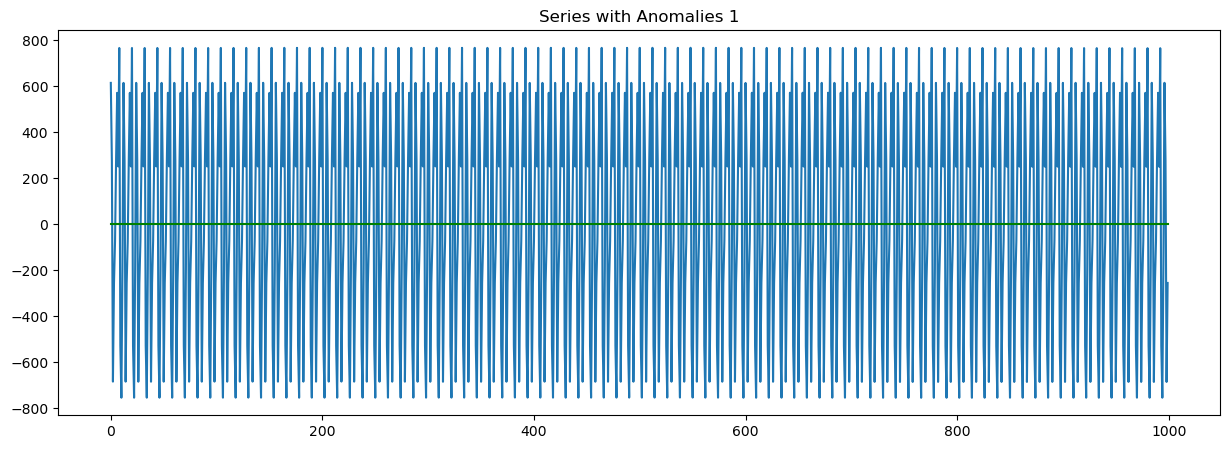

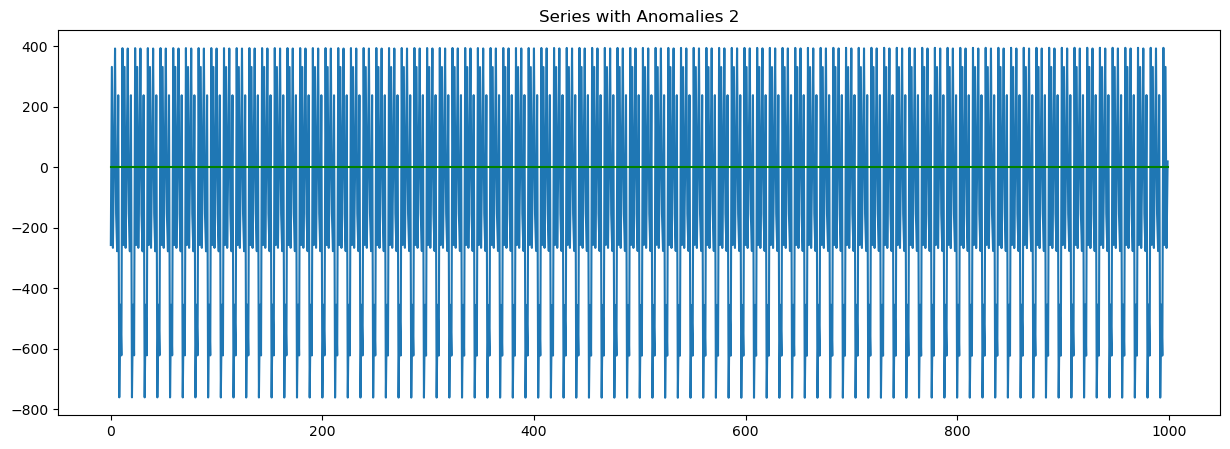

In [5]:
for (i,series) in enumerate(train[-2:]):
  plt.figure(figsize = (15,5))
  plt.plot(series['data'])
  plt.plot(series['anomaly'], color = 'green')
  plt.title(f'Series with Anomalies {i+1}')
  plt.show()

In [5]:
#Base Series with Anomalies

for length in [100, 400, 1000]:
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('white_noise')
        anomalies = ts.generate_point_anomalies(df=base)
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        anomalies = ts.generate_point_anomalies(df=base)
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        anomalies = ts.generate_point_anomalies(df=base)
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='mean')
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='mean')
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='mean')
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='variance')
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='variance')
        train.append(anomalies)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        anomalies = ts.generate_collective_anomalies(df=base, change_type='variance')
        train.append(anomalies)


#for (i,series) in enumerate(series_with_anomalies):
  #plt.figure(figsize = (15,5))
  #plt.plot(series['data'])
  #plt.plot(series['anomaly'], color = 'green')
  #plt.title(f'Series with Anomalies {i+1}')
  #plt.show()

In [6]:
#Base Series with Trend or Seasonality

for length in [100, 400, 1000]:
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        linear_trend_positive = ts.generate_deterministic_trend_linear(df=base, sign=1)
        train.append(linear_trend_positive)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        linear_trend_positive = ts.generate_deterministic_trend_linear(df=base, sign=1)
        train.append(linear_trend_positive)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        linear_trend_positive = ts.generate_deterministic_trend_linear(df=base, sign=1)
        train.append(linear_trend_positive)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        linear_trend_decrease = ts.generate_deterministic_trend_linear(df=base, sign=-1)
        train.append(linear_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        linear_trend_decrease = ts.generate_deterministic_trend_linear(df=base, sign=-1)
        train.append(linear_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        linear_trend_decrease = ts.generate_deterministic_trend_linear(df=base, sign=-1)
        train.append(linear_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df=base, sign=1)
        train.append(quadratic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df=base, sign=1)
        train.append(quadratic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df=base, sign=1)
        train.append(quadratic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df=base, sign=-1)
        train.append(quadratic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df=base, sign=-1)
        train.append(quadratic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df=base, sign=-1)
        train.append(quadratic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        cubic_trend_increase = ts.generate_deterministic_trend_cubic(df=base, sign=1)
        train.append(cubic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        cubic_trend_increase = ts.generate_deterministic_trend_cubic(df=base, sign=1)
        train.append(cubic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        cubic_trend_increase = ts.generate_deterministic_trend_cubic(df=base, sign=1)
        train.append(cubic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df=base, sign=-1)
        train.append(cubic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df=base, sign=-1)
        train.append(cubic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df=base, sign=-1)
        train.append(cubic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        stochastic_trend_increase = ts.generate_stochastic_trend(df=base, sign=1)
        train.append(stochastic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        stochastic_trend_increase = ts.generate_stochastic_trend(df=base, sign=1)
        train.append(stochastic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        stochastic_trend_increase = ts.generate_stochastic_trend(df=base, sign=1)
        train.append(stochastic_trend_increase)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        stochastic_trend_decrease = ts.generate_stochastic_trend(df=base, sign=-1)
        train.append(stochastic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        stochastic_trend_decrease = ts.generate_stochastic_trend(df=base, sign=-1)
        train.append(stochastic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        stochastic_trend_decrease = ts.generate_stochastic_trend(df=base, sign=-1)
        train.append(stochastic_trend_decrease)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ar')
        _, seasonality = ts.generate_seasonality(df=base)
        train.append(seasonality)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('ma')
        _, seasonality = ts.generate_seasonality(df=base)
        train.append(seasonality)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series('arma')
        _, seasonality = ts.generate_seasonality(df=base)
        train.append(seasonality)

#for (i,series) in enumerate(series_with_chars_test):
  #plt.figure(figsize = (15,5))
  #plt.plot(series['data'])
  #plt.title(f'Series with Trend or Seasonality {i+1}')
  #plt.show()

In [7]:
#Base Series with Trend or Seasonality and Anomalies

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_point_anomalies(df = linear_trend_positive)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_collective_anomalies(df = linear_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_point_anomalies(df = linear_trend_positive)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_collective_anomalies(df = linear_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_point_anomalies(df = linear_trend_positive)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    linear_trend_positive_anomalies = ts.generate_collective_anomalies(df = linear_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    linear_trend_negative_anomalies = ts.generate_point_anomalies(df = linear_trend_negative)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    linear_trend_negative_anomalies = ts.generate_collective_anomalies(df = linear_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    linear_trend_negative_anomalies = ts.generate_point_anomalies(df = linear_trend_negative)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    linear_trend_negative_anomalies = ts.generate_collective_anomalies(df = linear_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    linear_trend_negative_anomalies = ts.generate_point_anomalies(df = linear_trend_negative)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign =-1)
    linear_trend_negative_anomalies = ts.generate_collective_anomalies(df = linear_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(linear_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_point_anomalies(df = quadratic_trend_positive)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_point_anomalies(df = quadratic_trend_positive)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_point_anomalies(df = quadratic_trend_positive)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_positive = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    quadratic_trend_positive_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    quadratic_trend_negative_anomalies = ts.generate_point_anomalies(df = quadratic_trend_negative)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    quadratic_trend_negative_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    quadratic_trend_negative_anomalies = ts.generate_point_anomalies(df = quadratic_trend_negative)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    quadratic_trend_negative_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    quadratic_trend_negative_anomalies = ts.generate_point_anomalies(df = quadratic_trend_negative)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_negative = ts.generate_deterministic_trend_quadratic(df = base, sign =-1)
    quadratic_trend_negative_anomalies = ts.generate_collective_anomalies(df = quadratic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(quadratic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_point_anomalies(df = cubic_trend_positive)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_collective_anomalies(df = cubic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_point_anomalies(df = cubic_trend_positive)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_collective_anomalies(df = cubic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_point_anomalies(df = cubic_trend_positive)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_positive = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    cubic_trend_positive_anomalies = ts.generate_collective_anomalies(df = cubic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    cubic_trend_negative_anomalies = ts.generate_point_anomalies(df = cubic_trend_negative)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    cubic_trend_negative_anomalies = ts.generate_collective_anomalies(df = cubic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    cubic_trend_negative_anomalies = ts.generate_point_anomalies(df = cubic_trend_negative)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    cubic_trend_negative_anomalies = ts.generate_collective_anomalies(df = cubic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    cubic_trend_negative_anomalies = ts.generate_point_anomalies(df = cubic_trend_negative)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_negative = ts.generate_deterministic_trend_cubic(df = base, sign =-1)
    cubic_trend_negative_anomalies = ts.generate_collective_anomalies(df = cubic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(cubic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_point_anomalies(df = stochastic_trend_positive)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_point_anomalies(df = stochastic_trend_positive)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_point_anomalies(df = stochastic_trend_positive)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    stochastic_trend_positive_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_positive, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_positive_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    stochastic_trend_negative_anomalies = ts.generate_point_anomalies(df = stochastic_trend_negative)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    stochastic_trend_negative_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    stochastic_trend_negative_anomalies = ts.generate_point_anomalies(df = stochastic_trend_negative)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    stochastic_trend_negative_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    stochastic_trend_negative_anomalies = ts.generate_point_anomalies(df = stochastic_trend_negative)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign =-1)
    stochastic_trend_negative_anomalies = ts.generate_collective_anomalies(df = stochastic_trend_negative, change_type = 'mean', scale_factor = 0.6)
    train.append(stochastic_trend_negative_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_point_anomalies(df = seasonality)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_point_anomalies(df = seasonality)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_point_anomalies(df = seasonality)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'mean', scale_factor = 0.6)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'mean', scale_factor = 0.6)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    _, seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'mean', scale_factor = 0.6)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period , seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period , seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(seasonality_anomalies)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period , seasonality = ts.generate_seasonality(df = base)
    seasonality_anomalies = ts.generate_collective_anomalies(df = seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(seasonality_anomalies)

#for (i,series) in enumerate(series_with_chars_anomalies):
  #plt.figure(figsize = (15,5))
  #plt.plot(series['data'])
  #plt.plot(series['anomaly'], color = 'green')
  #plt.title(f'Series with Trend or Seasonality Anomalies {i+1}')
  #plt.show()

In [8]:
#Base Series with Trend and Seasonality

for length in [100, 400, 1000]:  
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    train.append(cubic_trend_decrease_seasonality)

#for (i,series) in enumerate(series_with_2_chars):
  #plt.figure(figsize = (15,5))
  #plt.plot(series)
  #plt.title(f'Series with Trend and Seasonality {i+1}')
  #plt.show()

In [9]:
#Base Series with Trend and Seasonality and Anomalies

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_point_anomalies(df = linear_trend_positive_seasonality)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_point_anomalies(df = linear_trend_positive_seasonality)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_point_anomalies(df = linear_trend_positive_seasonality)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_point_anomalies(df = linear_trend_negative_seasonality)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_point_anomalies(df = linear_trend_negative_seasonality)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_point_anomalies(df = linear_trend_negative_seasonality)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_point_anomalies(df = quadratic_trend_increase_seasonality)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_point_anomalies(df = quadratic_trend_increase_seasonality)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_point_anomalies(df = quadratic_trend_increase_seasonality)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_point_anomalies(df = quadratic_trend_decrease_seasonality)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_point_anomalies(df = quadratic_trend_decrease_seasonality)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_point_anomalies(df = quadratic_trend_decrease_seasonality)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_point_anomalies(df = cubic_trend_increase_seasonality)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_point_anomalies(df = cubic_trend_increase_seasonality)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_point_anomalies(df = cubic_trend_increase_seasonality)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_point_anomalies(df = cubic_trend_decrease_seasonality)
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_point_anomalies(df = cubic_trend_decrease_seasonality)
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_point_anomalies(df = cubic_trend_decrease_seasonality)
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'mean')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'mean')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'mean')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'mean')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'mean')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'mean')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'mean')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'mean')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'mean')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'mean')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'mean')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'mean')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'mean')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'mean')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'mean')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'mean')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'mean')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'mean')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'variance')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'variance')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    _,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'variance')
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'variance')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'variance')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    _,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'variance')
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'variance')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'variance')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    _,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'variance')
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'variance')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'variance')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    _,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'variance')
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'variance')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'variance')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    _,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'variance')
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'variance')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'variance')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    _,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'variance')
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    period ,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    period,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    period,linear_trend_positive_seasonality = ts.generate_seasonality(df = linear_trend_positive, scale_factor = 1)
    linear_trend_positive_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_positive_seasonality = ts.generate_collective_anomalies(df = linear_trend_positive_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_positive_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    period,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    period,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    period,linear_trend_negative_seasonality = ts.generate_seasonality(df = linear_trend_negative, scale_factor = 1)
    linear_trend_negative_seasonality['data'] += np.random.normal(0, 0.3, len(linear_trend_positive_seasonality))
    linear_trend_negative_seasonality = ts.generate_collective_anomalies(df = linear_trend_negative_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(linear_trend_negative_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    period,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    period,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_increase = ts.generate_deterministic_trend_quadratic(df = base, sign = 1)
    period,quadratic_trend_increase_seasonality = ts.generate_seasonality(df = quadratic_trend_increase, scale_factor = 1)
    quadratic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_increase_seasonality))
    quadratic_trend_increase_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    period,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    period,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    quadratic_trend_decrease = ts.generate_deterministic_trend_quadratic(df = base, sign = -1)
    period,quadratic_trend_decrease_seasonality = ts.generate_seasonality(df = quadratic_trend_decrease, scale_factor = 1)
    quadratic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(quadratic_trend_decrease_seasonality))
    quadratic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = quadratic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(quadratic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    period,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    period,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_increase = ts.generate_deterministic_trend_cubic(df = base, sign = 1)
    period,cubic_trend_increase_seasonality = ts.generate_seasonality(df = cubic_trend_increase, scale_factor = 1)
    cubic_trend_increase_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_increase_seasonality))
    cubic_trend_increase_seasonality = ts.generate_collective_anomalies(df = cubic_trend_increase_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_increase_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    period,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    period,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_decrease_seasonality)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    cubic_trend_decrease = ts.generate_deterministic_trend_cubic(df = base, sign = -1)
    period,cubic_trend_decrease_seasonality = ts.generate_seasonality(df = cubic_trend_decrease, scale_factor = 1)
    cubic_trend_decrease_seasonality['data'] += np.random.normal(0, 0.3, len(cubic_trend_decrease_seasonality))
    cubic_trend_decrease_seasonality = ts.generate_collective_anomalies(df = cubic_trend_decrease_seasonality, change_type = 'seasonal', seasonal_period = period)
    train.append(cubic_trend_decrease_seasonality)

#for (i,series) in enumerate(series_with_2_chars_anomalies):
  #plt.figure(figsize = (15,5))
  #plt.plot(series['data'])
  #plt.plot(series['anomaly'], color = 'red')
  #plt.title(f'Series with Trend and Seasonality and Anomalies {i+1}')
  #plt.show()

In [10]:
#Base Series with Mean Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_mean_shift)

#for (i,series) in enumerate(mean_shift_series):
    #plt.figure(figsize = (15,5))
    #plt.plot(series['data'])
    #plt.plot(series['mean_shift'], color = 'red')
    #plt.title(f'Series with Mean Shift {i+1}')
    #plt.show()

In [11]:
#Base Series + Chars + Mean Shifts

#Deterministic Linear Trend + Mean Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)
      
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.4)
    train.append(series_char_mean_shift)

  #Stochastic Trend + Mean Shift

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_char_mean_shift = ts.generate_stochastic_trend(df = base, sign = -1)
    series_stochastic_trend_negative_end_mean_decrease = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_char_mean_shift = ts.generate_stochastic_trend(df = base, sign = -1)
    series_stochastic_trend_negative_end_mean_decrease = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_mean_shift = ts.generate_mean_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3, scale_factor=0.5)
    train.append(series_char_mean_shift)

  #Seasonality and Mean Shifts

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1,seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base)
    series_char_mean_shift = ts.generate_mean_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period )
    train.append(series_char_mean_shift)

#for (i,series) in enumerate(mean_shift_chars_series):
    #plt.figure(figsize=(15, 5))
    #plt.title(f'Mean Shift {i+1}')
    #plt.plot(series['data'])
    #plt.plot(series['mean_shift'], color = 'red')
    #plt.show()

In [12]:
#Gradual Mean Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_middle_mean_decrease = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'middle', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, location = 'end', num_breaks= 1)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=2)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_gradual_mean_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_mean_shift = ts.generate_gradual_mean_shift(df = base, sign = -1, num_breaks=3)
    train.append(series_gradual_mean_shift)

#for i,series in enumerate(gradual_mean_shift_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['mean_shift'],color = 'red')
    #plt.title(f'Gradual Mean Shift {i+1}')
    #plt.show()

In [13]:
#Base Series with Variance Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'middle', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  location = 'end', num_breaks = 1)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=2)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = 1, num_breaks=3)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=3)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=3)
    train.append(series_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_var_shift = ts.generate_variance_shift(df = base, sign = -1,  num_breaks=3)
    train.append(series_var_shift)

#for (i,series) in enumerate(var_shift_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['variance_shift'],color='red')
    #plt.title(f'Variance Shift {i+1}')
    #plt.show()

In [14]:
#Base Series + Chars + Variance Shifts

#Deterministic Linear Trend + Variance Shifts
for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor=2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'beginning', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'middle', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, location = 'end', num_breaks= 1, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 2, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_positive = ts.generate_deterministic_trend_linear(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_positive, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)
      
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = 1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    linear_trend_negative = ts.generate_deterministic_trend_linear(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = linear_trend_negative, sign = -1, num_breaks= 3, scale_factor = 2)
    train.append(series_char_var_shift)

  #Stochastic Trend + Variance Shift

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1,scale_factor =2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'beginning', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'middle', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, location = 'end', num_breaks= 1,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 2,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_positive = ts.generate_stochastic_trend(df = base, sign = 1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_positive, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = 1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    stochastic_trend_negative = ts.generate_stochastic_trend(df = base, sign = -1)
    series_char_var_shift = ts.generate_variance_shift(df = stochastic_trend_negative, sign = -1, num_breaks= 3,scale_factor = 2)
    train.append(series_char_var_shift)

  #Seasonality + Variance Shifts

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)
      
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'beginning', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'middle', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, location = 'end', num_breaks= 1, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 2, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = 1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period,seasonal_series = ts.generate_seasonality(df = base)
    series_char_var_shift = ts.generate_variance_shift(df = seasonal_series, sign = -1, num_breaks= 3, seasonal_period = period)
    train.append(series_char_var_shift)

#for (i,series) in enumerate(var_shift_chars_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['variance_shift'],color='red')
    #plt.title(f'Variance Shift {i+1}')
    #plt.show()

In [15]:
#Gradual Variance Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign =1, location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign =1, location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'beginning', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'middle', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,location = 'end', num_breaks = 1, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1,  num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, num_breaks=2, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = 1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_var_shift = ts.generate_gradual_variance_shift(df = base, sign = -1, num_breaks=3, scale_factor = 2)
    train.append(series_gradual_var_shift)

#for i,series in enumerate(gradual_var_shift_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['variance_shift'],color='red')
    #plt.title(f'Gradual Variance Shift {i+1}')
    #plt.show()

In [16]:
#Base Series + Trend Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_trend_shift = ts.generate_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='magnitude_change', scale_factor = 5)
    series_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_trend_shift)

#for (i,series) in enumerate(trend_shift_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['trend_shift'],color='red')
    #plt.title(f'Trend Shift {i+1}')
    #plt.show()

In [17]:
#Base Series + Chars + Trend Shifts

scale_factor = 1
#Base Series + Seasonality + Trend Shifts
for length in [400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)
        
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = 1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='direction_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    period, seasonal_series = ts.generate_seasonality(df = base, scale_factor = 10)
    series_char_trend_shift = ts.generate_trend_shift(df = seasonal_series, sign = -1 , num_breaks = 2, change_type='magnitude_change', seasonal_period=period, scale_factor = scale_factor)
    series_char_trend_shift['data'] += np.random.normal(0, 0.05, length)
    train.append(series_char_trend_shift)

#for (i,series) in enumerate(trend_shift_chars_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['trend_shift'], color = 'red')
    #plt.title(f'Trend Shift {i+1}')
    #plt.show()

In [18]:
#Base Series + Gradual Trend Shift

for length in [100, 400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_beginning_trend_positive_magnitude = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_beginning_trend_positive_magnitude['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1, location = 'end' , num_breaks = 1, change_type='magnitude_change', scale_factor = 10)
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)


  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = 1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ar')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('ma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series('arma')
    series_gradual_trend_shift = ts.generate_gradual_trend_shift(df = base, sign = -1 , num_breaks = 2, change_type='direction_and_magnitude_change')
    series_gradual_trend_shift['data'] += np.random.normal(0, 0.1, length)
    train.append(series_gradual_trend_shift)

#for i,series in enumerate(gradual_trend_shift_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['trend_shift'],color='red')
    #plt.title(f'Gradual Trend Shift {i+1}')
    #plt.show()

In [19]:
#Base Series with Multiple Shifts
#Base Series + Mean Shift + Variance Shift

for length in [400, 1000]:
  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts = TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'middle', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, location = 'end', num_breaks = 1)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)
        
  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'beginning', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'middle', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, location = 'end', num_breaks = 1)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 2)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 2)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = 1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = 1, num_breaks = 3)
    train.append(series_mean_variance_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_mean_shift = ts.generate_mean_shift(df = base, sign = -1, num_breaks = 3)
    series_mean_variance_shift = ts.generate_variance_shift(df = series_mean_shift, sign = -1, num_breaks = 3)
    train.append(series_mean_variance_shift)

#for (i,series) in enumerate(multiple_shifts_series):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['mean_shift'], color = 'red')
    #plt.plot(series['variance_shift'], color = 'green')
    #plt.title(f'Multiple Shifts {i+1}')
    #plt.show()

In [20]:
#Base Series + Variance Shift + Trend Shift

for length in [400,1000]:
  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign= 1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign= 1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign= 1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='beginning',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='middle',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,location='end',num_breaks=1,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=2,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = -1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'beginning' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'middle' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

  for i in range(0,number):
    ts= TimeSeriesGenerator(length = length)
    base = ts.generate_base_series()
    series_variance_shift = ts.generate_variance_shift(df=base,sign=-1,num_breaks=3,scale_factor=3)
    series_var_trend_shift = ts.generate_trend_shift(df = series_variance_shift, sign = 1, location = 'end' ,num_breaks = 1, change_type='direction_and_magnitude_change')
    train.append(series_var_trend_shift)

#for (i,series) in enumerate(multiple_shifts_series_2):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['variance_shift'], color = 'red')
    #plt.plot(series['trend_shift'], color = 'green')
    #plt.title(f'Multiple Shifts {i+1}')
    #plt.show()

In [21]:
#Base Series + Mean Shifts + Trend Shifts

for length in [400,1000]:
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
            
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='beginning', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='middle', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)

    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, location='end', num_breaks=1, change_type='direction_and_magnitude_change', scale_factor=1)
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts = TimeSeriesGenerator(length=length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df=base, sign=-1, num_breaks=2, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1, scale_factor=0.3)
        train.append(series_mean_trend_shift)

    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)

    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)

    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)

    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='beginning', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='middle', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, num_breaks = 2, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1, location='end', num_breaks=1,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=2,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = 1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'beginning', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'middle', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)
    
    for i in range(0, number):
        ts= TimeSeriesGenerator(length = length)
        base = ts.generate_base_series()
        series_trend_shift = ts.generate_trend_shift(df = base, sign = -1, location = 'end', num_breaks = 1, change_type='direction_and_magnitude_change')
        series_mean_trend_shift = ts.generate_mean_shift(df=series_trend_shift, sign=-1,  num_breaks=3,scale_factor=0.3)
        train.append(series_mean_trend_shift)

#for (i,series) in enumerate(multiple_shifts_series_3):
    #plt.figure(figsize=(15, 5))
    #plt.plot(series['data'])
    #plt.plot(series['mean_shift'], color = 'red')
    #plt.plot(series['trend_shift'], color = 'green')
    #plt.title(f'Multiple Shifts {i+1}')
    #plt.show()

In [22]:
train_short = list()
train_medium = list()
train_long = list()

#val_short = list()
#val_medium = list()
#val_long = list()

#test_short = list()
#test_medium = list()
#test_long = list()

for series in train:
    series.reset_index(drop=True, inplace=True)
    if len(series) == 100:
     train_short.append(series)
    elif len(series) == 400:
     train_medium.append(series)
    elif len(series) == 1000:
     train_long.append(series)
    else:
        print('size not valid')

#for series in validation:
    #series.reset_index(drop=True, inplace=True)
#    if len(series) == 100:
#        val_short.append(series)
#    elif len(series) == 400:
#        val_medium.append(series)
#    else:
#        val_long.append(series)

#for series in test:
    #series.reset_index(drop=True, inplace=True)
#    if len(series) == 100:
#        test_short.append(series)
#    elif len(series) == 400:
#        test_medium.append(series)
#    else:
#       test_long.append(series)

In [23]:
save_data(train_short, "newdata/test_short.pkl")

In [24]:
save_data(train_medium, "newdata/test_medium.pkl")

In [25]:
save_data(train_long, "newdata/test_long.pkl")

In [ ]:
# save_data(train_short, "newdata/train_short.pkl")
# save_data(train_medium, "newdata/train_medium.pkl")
# save_data(train_long, "newdata/train_long.pkl")
#save_data(val_short, "newdata/val_short.pkl")
#save_data(val_medium, "newdata/val_medium.pkl")
#save_data(val_long, "newdata/val_long.pkl")
#save_data(test_short, "newdata/test_short.pkl")
#save_data(test_medium, "newdata/test_medium.pkl")
#save_data(test_long, "newdata/test_long.pkl")